In [4]:
from stsci.tools import capable
capable.OF_GRAPHICS = False
from pyraf import iraf
import sys,os,getopt
import pylab as pl
import numpy as np
import pyfits
from astropy.wcs import WCS
from astropy.io import fits
import progressbar
import time
iraf.noao.digiphot(_doprint=0)
iraf.noao.digiphot.daophot(_doprint=0)
%matplotlib inline

In [5]:
def createMasterDark(dark_folder,expectedExp,write_file=False):
    '''creates array of data from dark frames to create master dark frame of given exposure, folder must contain only dark frames
        returns array of mean data of given dark frames that can be used to subtract from original data, can save to fits file if write_file is True
        default is False'''
    workDir = dark_folder
    OutDir = workDir + 'masters/'
    OutFile = workDir + 'masters/' + 'mdark_' + str(expectedExp) + '.fits'
    values = []
    counter = 0
    files = (file for file in os.listdir(workDir) 
         if os.path.isfile(os.path.join(workDir, file)))
    
    for filename in files:
        img = pyfits.open(workDir+filename)
        data = img[0].data
        exp = img[0].header['EXPOSURE']
        if exp == expectedExp:
            counter += 1
            values.append(data) ####################
        img.close()          
    
    if counter == 0:
        print('No dark frames of given exposure')
        return
    else:
        outp=np.median(values,axis=0) 
        if write_file == False:
            return outp
        else:
            if not os.path.exists(OutDir) : os.mkdir(OutDir)
            hdu = pyfits.PrimaryHDU(outp)
            if os.path.exists(OutFile) : os.remove(OutFile)
            hdu.writeto(OutFile)
            print('Master dark file written to '+OutFile)
            return outp
        
        
def createMasterNormFlat(flat_folder,write_file=False):
    '''hopefully creates normalized flat fram from all flat frames in the given folder
         returns array of numbers
         can write to file if write_file is True'''
    workDir = flat_folder
    OutDir = workDir + 'masters/'
    OutFile = workDir + 'masters/' + 'mflat.fits'
    values = []
    counter = 0
    files = (file for file in os.listdir(workDir) 
         if os.path.isfile(os.path.join(workDir, file)))
    for filename in files:
        img = pyfits.open( workDir + filename )
        data = img[0].data
        counter += 1
        values.append(data)
    outp = np.median(values,axis=0)
    outp_mean = np.mean(outp)
    outp_final = outp / outp_mean
    if write_file == False:
        return outp_final
    else:
        if not os.path.exists(OutDir) : os.mkdir(OutDir)
        hdu = pyfits.PrimaryHDU(outp_final)
        if os.path.exists(OutFile) : os.remove(OutFile)
        hdu.writeto(OutFile)
        print('Master normalized flat file written to '+OutFile)
        return outp_final
    
    
def applyDarkFlat( file , dark , flat ):
    '''input file to apply reduction to, dark and flat arrays
        creates alternative file with suffix df to show that dark frames and flat fields were applied'''    
    OutFile= file[:-5] + 'df.fits'
    
    
    img = pyfits.open( file ) 
    data = ( img[0].data - dark ) / flat
    header = img[0].header
    
    if os.path.exists( OutFile) : os.remove( OutFile ) 
    pyfits.writeto( OutFile , data , header )
    #print( 'Frame ' + file + ' processed and written to ' + OutFile )
    
def SkyToPx(infile,outfile,FITS):
    '''converts sky coords to px positions on given frame.
    coords fmt is RA,DE for each object. Output is X,Y'''
    header=fits.getheader(FITS)
    w=WCS(header)
    data=np.loadtxt(infile,comments='#')
    n=len(data)
    k=0
    pxc=[]
    for i,j in data:
        a,b=w.wcs_world2pix(i,j,1)
        pxc.append([float(a),float(b)])
    np.savetxt(outfile,pxc)

In [6]:
darks=createMasterDark('data/optic-ondr/d50/20131030/C0/darks/',20,True)
flat=createMasterNormFlat('data/optic-ondr/d50/20131030/C0/flats/',True)

Master dark file written to data/optic-ondr/d50/20131030/C0/darks/masters/mdark_20.fits
Master normalized flat file written to data/optic-ondr/d50/20131030/C0/flats/masters/mflat.fits


In [7]:
imageDir='data/optic-ondr/d50/20131030/C0/51018/'
files = [file for file in os.listdir(imageDir)
         if 'df' not in file
         if os.path.isfile(os.path.join(imageDir, file))]


bar = progressbar.ProgressBar()
for file in bar(files):
    applyDarkFlat(imageDir+file,darks,flat)

100% (301 of 301) |#######################| Elapsed Time: 0:01:18 Time: 0:01:18


In [11]:
OutDir='photout/'
StarCoordFile='grbstarcoords.dat'
CoordsFile='coord.coo.1'
removeGarbage=1
FinalOut=OutDir+'Phot.dat'
if os.path.exists(FinalOut): os.remove(FinalOut)
    
InDir='data/optic-ondr/d50/20131030/C0/51018/'
FileList=[]
FileList=[file for file in os.listdir(InDir)
          if file.endswith('df.fits')
          if os.path.isfile(os.path.join(InDir, file))]
FileList.sort()
FileList
                                    

['20131030205719-387-RAdf.fits',
 '20131030205758-645-RAdf.fits',
 '20131030205835-372-RAdf.fits',
 '20131030205912-067-RAdf.fits',
 '20131030205948-744-RAdf.fits',
 '20131030210025-427-RAdf.fits',
 '20131030210102-064-RAdf.fits',
 '20131030210138-768-RAdf.fits',
 '20131030210215-447-RAdf.fits',
 '20131030210252-116-RAdf.fits',
 '20131030210328-788-RAdf.fits',
 '20131030210405-429-RAdf.fits',
 '20131030210442-096-RAdf.fits',
 '20131030210518-770-RAdf.fits',
 '20131030210555-437-RAdf.fits',
 '20131030210632-141-RAdf.fits',
 '20131030210708-815-RAdf.fits',
 '20131030210745-488-RAdf.fits',
 '20131030210822-127-RAdf.fits',
 '20131030210858-831-RAdf.fits',
 '20131030210935-503-RAdf.fits',
 '20131030211012-179-RAdf.fits',
 '20131030211048-806-RAdf.fits',
 '20131030211125-515-RAdf.fits',
 '20131030211202-188-RAdf.fits',
 '20131030211238-863-RAdf.fits',
 '20131030211315-497-RAdf.fits',
 '20131030211352-203-RAdf.fits',
 '20131030211430-360-RAdf.fits',
 '20131030211505-528-RAdf.fits',
 '20131030

In [12]:
arrayoutp=[]
bar=progressbar.ProgressBar()
'''needs to be reworked using more functions / mess but works so far'''
for file in bar(FileList):
    Base=file.split('-')[0]
    DaoPhotOut=OutDir+Base+'.mag.dat'
    if not os.path.exists(OutDir): os.mkdir(OutDir)
    InFile=InDir+file
    PhotTxOut=OutDir+Base+'PhotTXout.dat'
    SkyToPx(StarCoordFile,CoordsFile,InFile)
    #centerpars = iraf.centerpars.getParList()
    #skypars    = iraf.fitskypars.getParList()
    photpars   = iraf.photpars.getParList() #parametry - apertura
    iraf.photpars.setParam('apertures',4)
    iraf.phot.setParam('image',InFile)
    iraf.phot.setParam('coords',CoordsFile)
    iraf.phot.setParam('verify','no')
    iraf.phot.setParam('output',DaoPhotOut)
    iraf.phot.setParam('interactive','no')
    #iraf.phot.saveParList('daophot.par')
    if os.path.exists(DaoPhotOut) : os.remove(DaoPhotOut) #vaa IRAF neumi prepisovat soubory, crashne pri existenci
    dump=iraf.phot(mode='h',Stdout=1)
    if os.path.exists(PhotTxOut) : os.remove(PhotTxOut) #opet overwrite
    iraf.txdump(DaoPhotOut,'XCENTER,YCENTER,MAG,MERR','yes',Stdout = PhotTxOut)
    if removeGarbage == 1: os.remove(DaoPhotOut)
    pic=pyfits.open(InDir+file)
    timestamp=pic[0].header["JD"] + (pic[0].header["EXPOSURE"]/2/3600/24 )
    line=''+str(timestamp)+'\t'  #writing a better formated file 'Target mag, target magerr , comp stars, comp starerr, .. , .. ,.. ,
    outp=np.loadtxt(PhotTxOut)
    for lines in enumerate(open(CoordsFile)):
        line+=str(outp[lines[0],2])+"\t"+str(outp[lines[0],3])+"\t"
    line+="\n"
    finout=open(FinalOut,'a')
    finout.write(line)
    finout.close()
        
    arrayoutp.append(line)

N/A% (0 of 301) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING: FITSFixedWarning: RADECSYS= 'FK5 ' / Coordinate system 
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
100% (301 of 301) |#######################| Elapsed Time: 0:00:38 Time: 0:00:38


In [13]:
lc_dat = np.loadtxt('photout/Phot.dat')
lc_dat

array([[  2.45659637e+06,   1.34930000e+01,   6.00000000e-03, ...,
          1.00000000e-03,   9.51700000e+00,   1.00000000e-03],
       [  2.45659637e+06,   1.35180000e+01,   7.00000000e-03, ...,
          1.00000000e-03,   9.56600000e+00,   1.00000000e-03],
       [  2.45659637e+06,   1.35630000e+01,   7.00000000e-03, ...,
          1.00000000e-03,   9.53500000e+00,   1.00000000e-03],
       ..., 
       [  2.45659650e+06,   1.91100000e+01,   6.59000000e-01, ...,
          1.00000000e-03,   1.09690000e+01,   2.00000000e-03],
       [  2.45659650e+06,   1.97580000e+01,   1.20600000e+00, ...,
          1.00000000e-03,   1.10620000e+01,   2.00000000e-03],
       [  2.45659650e+06,   1.85810000e+01,   4.29000000e-01, ...,
          1.00000000e-03,   1.10150000e+01,   2.00000000e-03]])

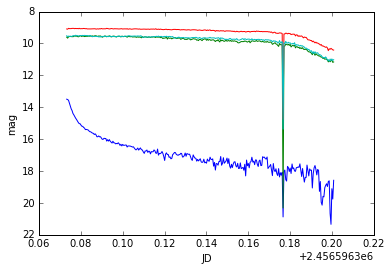

In [17]:
pl.plot(lc_dat[:,0],lc_dat[:,1])
pl.plot(lc_dat[:,0],lc_dat[:,3])
pl.plot(lc_dat[:,0],lc_dat[:,5])
pl.plot(lc_dat[:,0],lc_dat[:,7])
pl.ylim(22,8)
pl.ylabel('mag')
pl.xlabel('JD')
pl.show()